In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#impport packages
import math
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
import pickle
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [3]:
#read dataframe
df = pd.read_csv('/content/drive/MyDrive/FER_CNN_SVM/fer2013/fer2013.csv')
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [4]:
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}
emotion_text_to_label = {v:k for k,v in emotion_label_to_text.items()}


<Axes: xlabel='emotion', ylabel='count'>

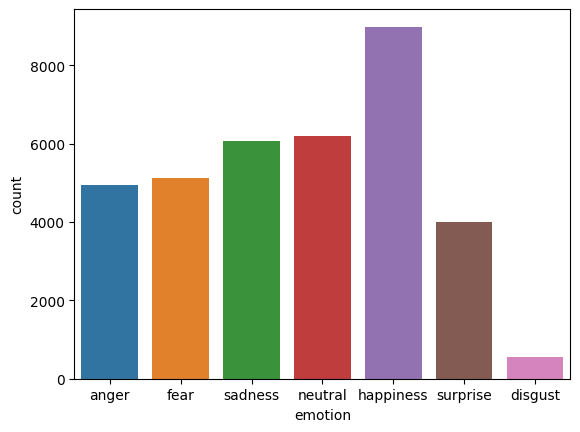

In [5]:
#countplot
sns.countplot(data=df, x=df.emotion.map(emotion_label_to_text))

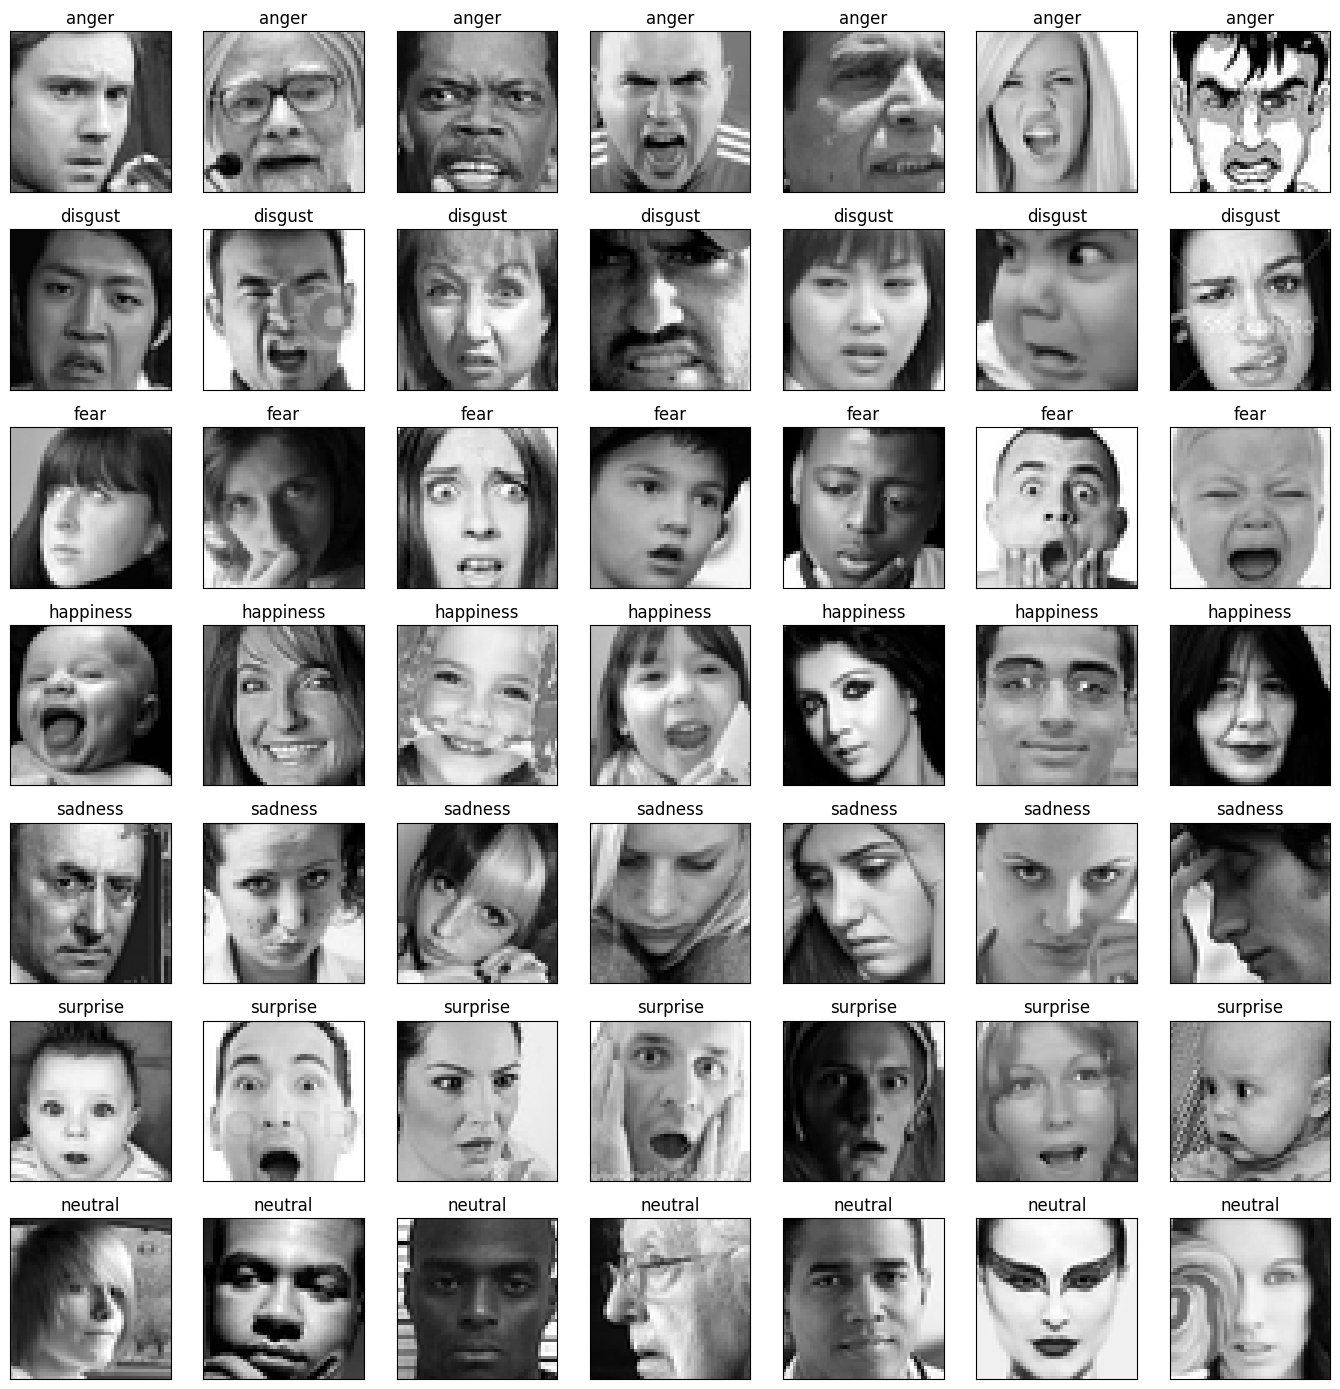

In [6]:
#visualize samples of each class
fig = pyplot.figure(1, (14, 14))

k = 0
for label in sorted(df.emotion.unique()):
    for j in range(7):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = pyplot.subplot(7, 7, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        pyplot.tight_layout()


In [7]:
#to array conversion
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
img_array = np.stack(img_array, axis=0)

In [ ]:
#train-test split
X_train, X_valid, y_train, y_valid = train_test_split(img_array, df.emotion,
                                                    shuffle=True, stratify=df.emotion,
                                                    test_size=0.1, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

In [ ]:
#convert 2d data into 1d for SVM
X_train = X_train.reshape(X_train.shape[0], -1)
X_valid = X_valid.reshape(X_valid.shape[0], -1)
X_train.shape, X_valid.shape

##SVM fit the model

In [ ]:
#fit the polynomial kernel to the SVC with regularization=1
svc = SVC(kernel = 'poly', C=10)
svc.fit(X_train, y_train)

SVC(C=10, kernel='poly')

In [ ]:
#model's performance
y_test_pred = svc.predict(X_valid)
print(classification_report(y_valid, y_test_pred))

              precision    recall  f1-score   support

           0       0.31      0.35      0.33       495
           1       0.22      0.38      0.28        55
           2       0.31      0.33      0.32       512
           3       0.58      0.57      0.58       899
           4       0.35      0.32      0.33       608
           5       0.58      0.56      0.57       400
           6       0.43      0.38      0.41       620

    accuracy                           0.43      3589
   macro avg       0.40      0.42      0.40      3589
weighted avg       0.43      0.43      0.43      3589



In [ ]:
# Save the trained model as a pickle string.
pickle.dump(svc, open('fwe_model.pkl', 'wb'))

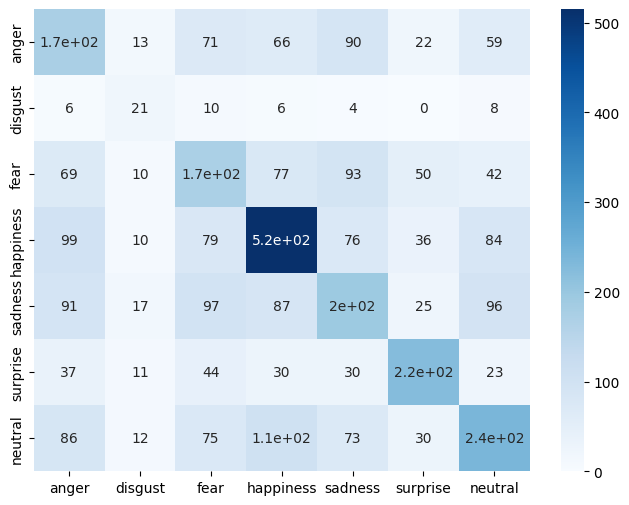

In [ ]:
#confusion matrix
emotion_label_to_text = ['anger', 'disgust', 'fear', 'happiness', 'sadness', 'surprise', 'neutral']

k1 = confusion_matrix(y_valid, y_test_pred)

fig, ax = plt.subplots(figsize=(8,6))
sns_plot = sns.heatmap(k1, annot=True, cmap='Blues',xticklabels = emotion_label_to_text, 
                       yticklabels = emotion_label_to_text)
fig1 = sns_plot.get_figure()


#Visualize decision boundary of SVM

In [8]:
#squeeze the data
img_array_ = img_array.reshape(img_array.shape[0], -1)

#normalize the data
img_array_ = img_array_/255

#convert it into 2d space for visualizing the decision boundary
pca = PCA(n_components=2)
Xreduced = pca.fit_transform(img_array_)

In [9]:

def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

In [10]:
Xreduced.shape, df.emotion.shape

((35887, 2), (35887,))

In [11]:
del img_array
del img_array_

In [12]:
#choose 20 samples from each class for representation
Xreduced_20samples, yreduced_20samples = [], []

for k,_ in emotion_label_to_text.items():
  idx = list(df[df.emotion==k][:20].index)
  Xreduced_20samples.extend(Xreduced[idx])
  yreduced_20samples.extend([k]*20)

In [13]:
#to array conversion
Xreduced_20samples = np.array(Xreduced_20samples)
yreduced_20samples = np.array(yreduced_20samples)

In [14]:
#fit linear kernel for visualization
model = SVC(kernel='poly')
clf = model.fit(Xreduced_20samples, yreduced_20samples)

<ipython-input-17-317683f6e648>:14: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(temp_X0, temp_X1, cmap=plt.cm.coolwarm, s=20, edgecolors='k', label=emotion_label_to_text[k], c=color[i])


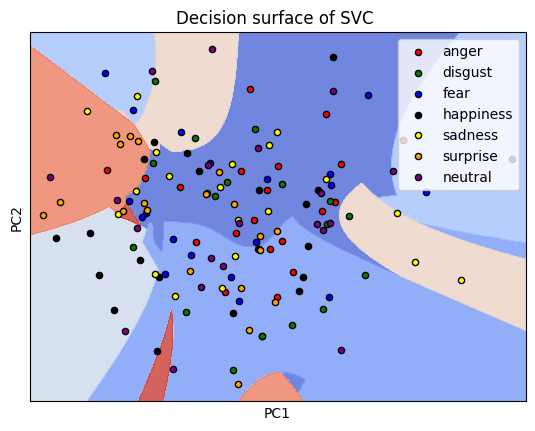

In [17]:

fig, ax = plt.subplots()
# title for the plots
title = ('Decision surface of SVC ')
# Set-up grid for plotting.
X0, X1 = Xreduced_20samples[:, 0], Xreduced_20samples[:, 1]
xx, yy = make_meshgrid(X0, X1)


plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
color = ['red', 'green', 'blue', 'black', 'yellow', 'orange', 'purple']
i = 0
for k,_ in emotion_label_to_text.items():
  temp_X0, temp_X1 = X0[yreduced_20samples==k], X1[yreduced_20samples==k]
  ax.scatter(temp_X0, temp_X1, cmap=plt.cm.coolwarm, s=20, edgecolors='k', label=emotion_label_to_text[k], c=color[i])
  i += 1

ax.set_ylabel('PC2')
ax.set_xlabel('PC1')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title(title)
ax.legend()
plt.show()